[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.sandbox.google.com/github/kornia/tutorials/blob/master/source/extract-combine-patches.ipynb)

# Extracting and Combining Tensor Patches

In this tutorial we will show how you can extract and combine tensor patches using kornia

## Install and get data

In [ ]:
%%capture
%matplotlib inline
# Get sample data
!wget https://tinypng.com/images/social/website.jpg -O panda.jpg
# Install latest kornia
!pip install git+https://github.com/kornia/kornia

In [ ]:
import cv2
import matplotlib.pyplot as plt
import torch
from kornia.contrib import (
    CombineTensorPatches,
    ExtractTensorPatches,
    combine_tensor_patches,
    extract_tensor_patches,
)
from kornia.utils import image_to_tensor, tensor_to_image

## Using Modules

In [ ]:
h, w = 8, 8
win = 4
pad = 2

image = torch.randn(2, 3, h, w)
print(image.shape)
tiler = ExtractTensorPatches(window_size=win, stride=win, padding=pad)
merger = CombineTensorPatches(original_size=(h, w), window_size=win, unpadding=pad)
image_tiles = tiler(image)
print(image_tiles.shape)
new_image = merger(image_tiles)
print(new_image.shape)
assert (image == new_image).all()

torch.Size([2, 3, 8, 8])
torch.Size([2, 9, 3, 4, 4])
torch.Size([2, 3, 8, 8])


## Using Functions

In [ ]:
h, w = 8, 8
win = 4
pad = 2

image = torch.randn(1, 1, h, w)
print(image.shape)
patches = extract_tensor_patches(image, window_size=win, stride=win, padding=pad)
print(patches.shape)
restored_img = combine_tensor_patches(patches, original_size=(h, w), window_size=win, stride=win, unpadding=pad)
print(restored_img.shape)
assert (image == restored_img).all()

torch.Size([1, 1, 8, 8])
torch.Size([1, 9, 1, 4, 4])
torch.Size([1, 1, 8, 8])


While using these functions, it is important to keep track of the following points:

1. Image after padding must be divisible by window_size 
2. CombineTensorPatches only works with stride == window_size (PRs are welcome)

## Padding

All parameters of extract and combine functions accept a **single int** or **tuple of two ints**. Padding (for extract) and unpadding (for combine) also accept a **tuple of four ints**. Since padding is an integral part of these functions, it's important to note the following:

- If padding is `p` -> it means both height and width are padded by `2*p`
- If padding is `(ph, pw)` -> it means height is padded by `2*ph` and width is padded by `2*pw` 
- If padding is `(p1, p2, p3, p4)` -> it means image is padded by `p1` at the top, by `p2` at the bottom, by `p3` on the left, and by `p4` on the right.

### Examples

In [ ]:
def extract_and_combine(image, window_size, padding):
    h, w = image.shape[-2:]
    tiler = ExtractTensorPatches(window_size=window_size, stride=window_size, padding=padding)
    merger = CombineTensorPatches(original_size=(h, w), window_size=window_size, unpadding=padding)
    image_tiles = tiler(image)
    print(f"Shape of tensor patches = {image_tiles.shape}")
    merged_image = merger(image_tiles)
    print(f"Shape of merged image = {merged_image.shape}")
    assert (image == merged_image).all()
    return merged_image

In [ ]:
image = torch.randn(2, 3, 9, 9)
_ = extract_and_combine(image, window_size=(4, 4), padding=(2, 1, 2, 1))

Shape of tensor patches = torch.Size([2, 9, 3, 4, 4])
Shape of merged image = torch.Size([2, 3, 9, 9])


Why is padding = (2, 1, 2, 1)?

Recall that we need to ensure the padded image is divisible by `window_size`. The image is of size `(9, 9)` and `window_size` = `(4, 4)`, so we need to pad it by 3 units. In the cell above we padded the top by 2, bottom by 1, left by 2 and right by 1 i.e. `padding = (2, 1, 2, 1)`. You could have also used `padding = (1, 2, 1, 2)` to achieve the same result.


In [ ]:
image = torch.randn(2, 3, 9, 9)
_ = extract_and_combine(image, window_size=(4, 4), padding=(1, 2, 1, 2))

Shape of tensor patches = torch.Size([2, 9, 3, 4, 4])
Shape of merged image = torch.Size([2, 3, 9, 9])


These functions also work with rectangular images

In [ ]:
rect_image = torch.randn(1, 1, 8, 6)
print(rect_image.shape)

torch.Size([1, 1, 8, 6])


If we use the same `window_size = (4,4)`, we can see that the height (8) is already divisible by `window_size` but this is not the case for width (6). To fix this, we just need to pad the width dimension by 2

In [ ]:
restored_image = extract_and_combine(rect_image, window_size=(4, 4), padding=(0, 1))

Shape of tensor patches = torch.Size([1, 4, 1, 4, 4])
Shape of merged image = torch.Size([1, 1, 8, 6])


Recall that when padding is a tuple of ints `(ph, pw)`, the height and width are padded by `2*ph` and `2*pw` respectively.

In [ ]:
# Confirm that the original image and restored image are the same
assert (restored_image == rect_image).all()

Let's now visualize how extraction and combining works.

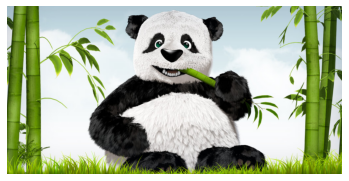

In [ ]:
# Load sample image
img = cv2.imread("panda.jpg", cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
h, w = img.shape[:2]

plt.imshow(img)
plt.axis("off");

For extraction we need image to be a tensor of shape `BCHW`

In [ ]:
# Convert img array to img tensor
img_tensor = image_to_tensor(img).float() / 255.0
img_tensor = img_tensor.unsqueeze(0)
print(img_tensor.shape)

torch.Size([1, 3, 510, 1020])


We will use `window_size = (400, 400)` to extract 6 tiles of shape `(400, 400)` and visualize them.

In [ ]:
# Set window size
win = 400
# Calculate required padding
h_pad = (win - (h % win)) // 2
w_pad = (win - (w % win)) // 2
pad = (h_pad, w_pad)

tiler = ExtractTensorPatches(window_size=win, stride=win, padding=pad)
image_tiles = tiler(img_tensor)
print(f"Shape of image tiles = {image_tiles.shape}")

Shape of image tiles = torch.Size([1, 6, 3, 400, 400])


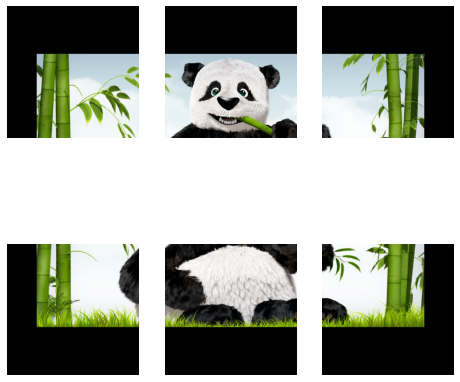

In [ ]:
# Create the plot
fig, axs = plt.subplots(2, 3, figsize=(8, 8))
axs = axs.ravel()

for i in range(len(image_tiles[0])):
    axs[i].axis("off")
    axs[i].imshow(tensor_to_image(image_tiles[0][i]))

plt.show()

Finally, let's combine the patches and visualize the resulting image

Shape of restored image = torch.Size([1, 3, 510, 1020])


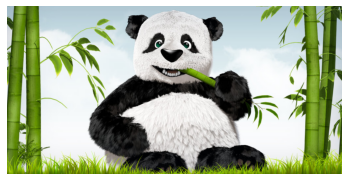

In [ ]:
merger = CombineTensorPatches(original_size=(h, w), window_size=win, unpadding=pad)
merged_image = merger(image_tiles)
print(f"Shape of restored image = {merged_image.shape}")

plt.imshow(tensor_to_image(merged_image[0]))
plt.axis("off");